In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import webbrowser
import matplotlib.image as mpimg
from pandas.core.common import SettingWithCopyWarning
import warnings
import pytz
from datetime import timedelta, datetime
from typing import  Optional
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df_originial = pd.read_excel("hotel_data.xlsx")
df = df_originial
df.head()

In [ ]:
df.isna().sum()

_id                         0
bookingId                   0
bookingGroupId          39609
status                      0
requestedAreaType_id        0
adultCount                  0
childCount                  0
channelManager          72345
currencyCode                0
start                       0
end                         0
area                       23
areaType                    0
bookingCreatedAt            0
bookingCancelledAt      41773
ratePlan                    0
market__code              738
market__description       738
source__code              150
source__description       150
origin__code            72345
origin__description     72345
night__start                0
night__netAmount            0
night__taxAmount            0
night__grossAmount          0
night__bookingNight         0
dtype: int64

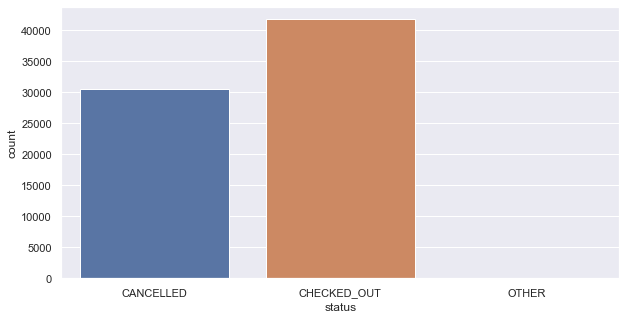

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x = df['status'])
plt.show()

In [ ]:
df = df[df['status'] != 'CANCELLED']

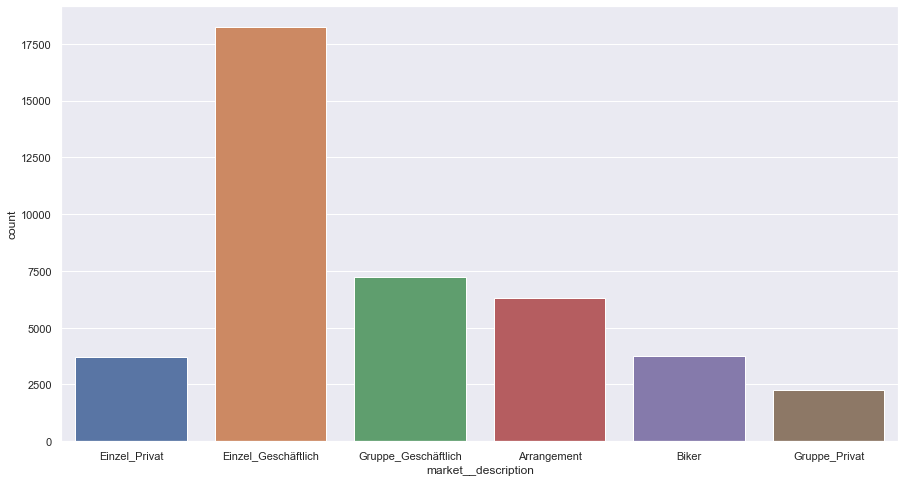

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(x = df['market__description'])
plt.show()

For each night of a stay a new dataset is created. Following example shows a booking of two guests who stayed three nights in the hotel. Therefore three datasets were created. For the analysis part this could lead to problems. Thats why only one dataset will be kept per bookingId.

In [ ]:
df[df['bookingId'] == 76877]

,_id,bookingId,bookingGroupId,status,requestedAreaType_id,adultCount,childCount,channelManager,currencyCode,start,...,market__description,source__code,source__description,origin__code,origin__description,night__start,night__netAmount,night__taxAmount,night__grossAmount,night__bookingNight
2,6064ecc3a39151aa0f3f5341,76877,NaN,CHECKED_OUT,5f22664e58b6c90cbd9d6780,2,0,NaN,EUR,2017-03-28T14:00:00:0000,...,Einzel_Privat,Telefon,Telefon,NaN,NaN,2017-03-28T14:00:00:0000,8692,608,9300,1
3,6064ecc3a39151aa0f3f5341,76877,NaN,CHECKED_OUT,5f22664e58b6c90cbd9d6780,2,0,NaN,EUR,2017-03-28T14:00:00:0000,...,Einzel_Privat,Telefon,Telefon,NaN,NaN,2017-03-29T14:00:00:0000,8692,608,9300,2
4,6064ecc3a39151aa0f3f5341,76877,NaN,CHECKED_OUT,5f22664e58b6c90cbd9d6780,2,0,NaN,EUR,2017-03-28T14:00:00:0000,...,Einzel_Privat,Telefon,Telefon,NaN,NaN,2017-03-30T14:00:00:0000,8692,608,9300,3


In [ ]:
idx = df.groupby(['_id'])['night__bookingNight'].transform(max) == df['night__bookingNight']
df = df[idx]

In [ ]:
#formating date columns with the right date format

df['start'] = pd.to_datetime(df['start'], format= "%Y-%m-%dT%H:%M:%S:%f").dt.date

df['month'] = pd.DatetimeIndex(df['start']).month
df['year'] = pd.DatetimeIndex(df['start']).year
df['week'] = pd.DatetimeIndex(df['start']).week
df['weekday'] = pd.DatetimeIndex(df['start']).weekday

df['bookingCreatedAt'] = pd.to_datetime(df['bookingCreatedAt'], format= "%Y-%m-%dT%H:%M:%S:%f").dt.date
df['bookingCancelledAt'] = pd.to_datetime(df['bookingCancelledAt'], format= "%Y-%m-%dT%H:%M:%S:%f").dt.date
df['night__start'] = pd.to_datetime(df['night__start'], format= "%Y-%m-%dT%H:%M:%S:%f").dt.date

## Daily guests in 2019

Text(0, 0.5, 'guests')

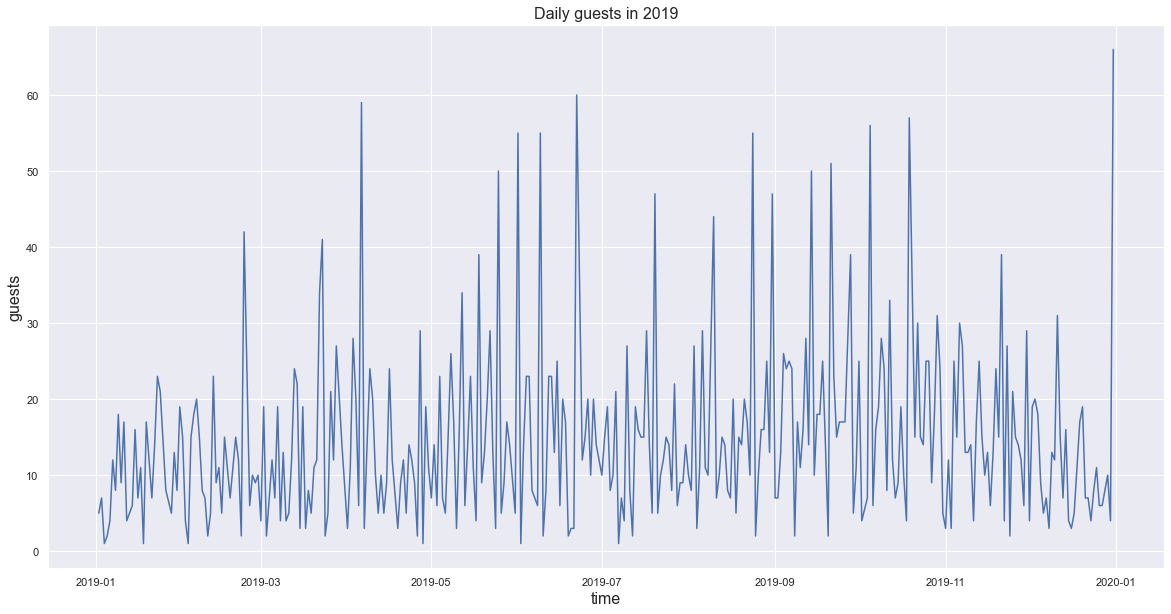

In [ ]:
df['guests'] = df['adultCount'] + df['childCount']

df_2019 = df[df['year'] == 2019]
plt.figure(figsize=(20,10))

df_2019_date = df_2019.groupby('night__start').sum()
plt.plot(df_2019_date.index, df_2019_date.guests)
plt.title('Daily guests in 2019', fontsize=16)
plt.xlabel('time', fontsize=16)
plt.ylabel('guests', fontsize=16)

## Average guests per month

In [ ]:
monthly_guests = df.groupby(['month', 'year'])['guests'].sum()
monthly_guests = monthly_guests.groupby('month').mean()

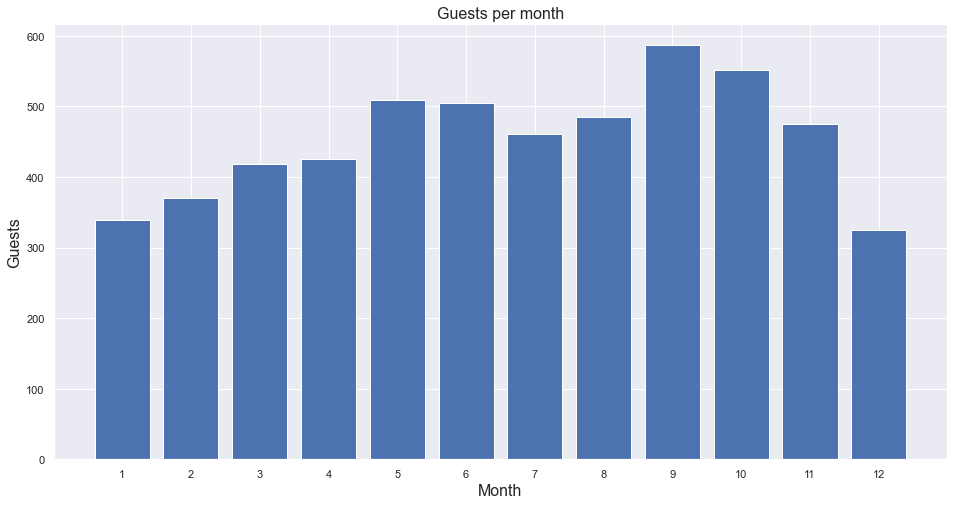

In [ ]:
plt.figure(figsize=(16, 8))
plt.bar(monthly_guests.index, monthly_guests)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Guests", fontsize=16)
plt.title("Guests per month", fontsize=16)
plt.xticks(monthly_guests.index)
plt.show()

### Length of stay

Shows how many nights the average guest stays at the hotel.

In [ ]:
num_nights = list(df["night__bookingNight"].value_counts().index)
num_bookings = list(df["night__bookingNight"].value_counts())
rel_bookings = df["night__bookingNight"].value_counts() / sum(num_bookings) * 100 # convert to percent


nights = pd.DataFrame({"num_nights": num_nights, "rel_num_bookings": rel_bookings})

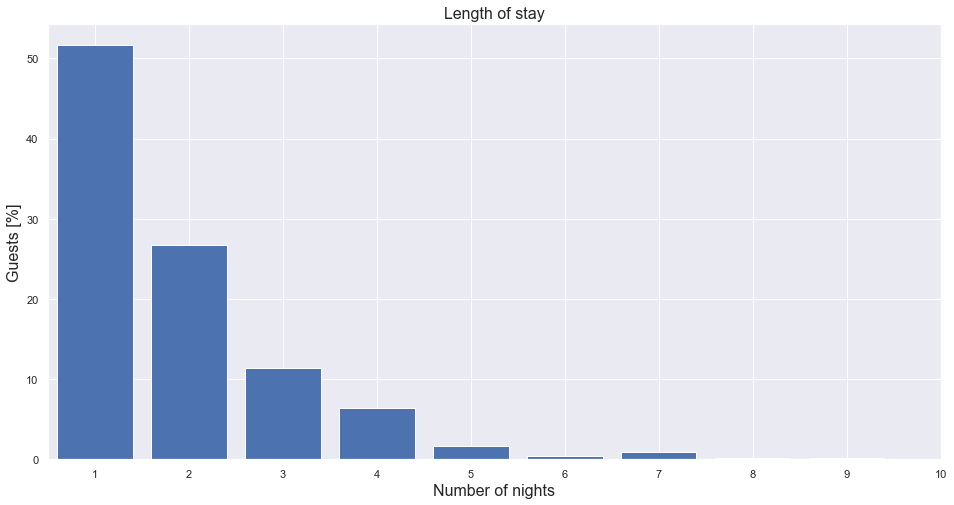

In [ ]:
plt.figure(figsize=(16, 8))
plt.bar(nights.num_nights, nights.rel_num_bookings)
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.xticks(num_nights)
plt.xlim(0.5,10)
plt.show()

## Length of stay (Individual guests vs groups)

In [ ]:
group_nights = df.groupby(["bookingGroupId"]).night__bookingNight.max().to_frame(name = 'GroupNightStay').reset_index()
individual_nights = df[df['bookingGroupId'].isnull()]

individual_nights_index = list(individual_nights["night__bookingNight"].value_counts().index)
individual_nights_num = list(individual_nights["night__bookingNight"].value_counts())
individual_nights_rel = individual_nights["night__bookingNight"].value_counts() / sum(individual_nights_num) * 100 # convert to percent

group_nights_index = list(group_nights["GroupNightStay"].value_counts().index)
group_nights_num = list(group_nights["GroupNightStay"].value_counts())
group_nights_rel = group_nights["GroupNightStay"].value_counts() / sum(group_nights_num) * 100

nights = pd.DataFrame({ "num_nights_h1": individual_nights_index,
                        "individual_nights_rel": individual_nights_rel,
                        "group_nights_rel": group_nights_rel})

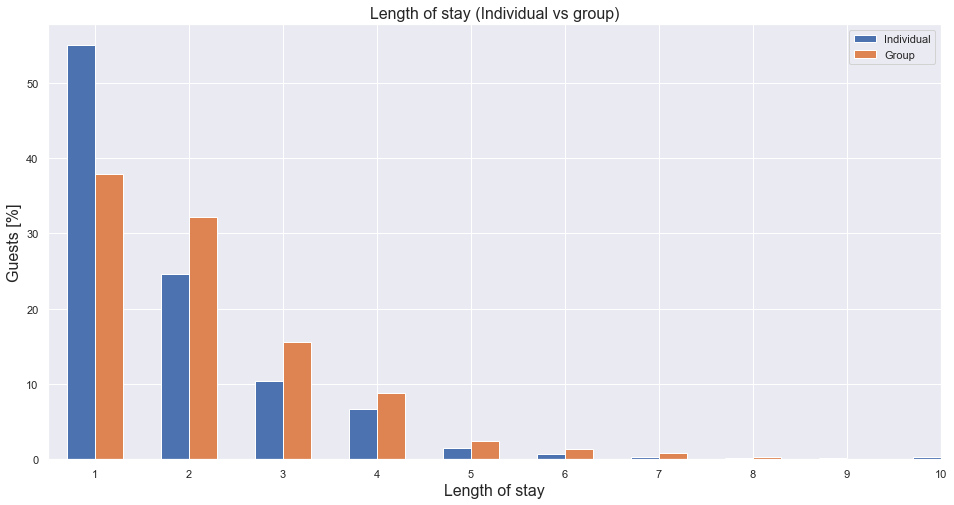

In [ ]:
plt.figure(figsize=(16,8))
plt.bar(nights.num_nights_h1-0.15, nights.individual_nights_rel, width=0.3, label='Individual')
plt.bar(nights.num_nights_h1+0.15, nights.group_nights_rel, width=0.3, label='Group')
plt.xticks(nights.num_nights_h1)
plt.xlim(0.5,10)
plt.title('Length of stay (Individual vs group)', fontsize=16)
plt.xlabel('Length of stay', fontsize=16)
plt.ylabel('Guests [%]', fontsize=16)
plt.legend()
plt.show()

## Time to arrival (Individual vs Group)
Time to arrival = number of days between the create date of the booking and the stay date

In [ ]:
individual_tta = df[df['bookingGroupId'].isnull()]
group_tta = df.groupby(["bookingGroupId"]).first()

individual_tta['time_to_arrival_days'] = (individual_tta['start'] - individual_tta['bookingCreatedAt']) / np.timedelta64(1, 'D')
group_tta['time_to_arrival_days'] = (group_tta['start'] - group_tta['bookingCreatedAt']) / np.timedelta64(1, 'D')

In [ ]:
individual_tta['bins'] = pd.cut(individual_tta['time_to_arrival_days'],bins=[0, 10,20,50, 99, 200, 365,5000], 
                           labels=["0-10 days", "11-20 days", "21-50 days","51-99 days","100-200 days", "201-365 days", "366 days+"])
group_tta['bins'] = pd.cut(group_tta['time_to_arrival_days'],bins=[0, 10,20,50, 99, 200, 365,5000], 
                           labels=["0-10 days", "11-20 days", "21-50 days","51-99 days","100-200 days", "201-365 days", "366 days+"])

In [ ]:
individual_tta_index = list(individual_tta["bins"].value_counts().index.sort_values())
individual_tta_num = list(individual_tta["bins"].value_counts())
individual_tta_rel = individual_tta["bins"].value_counts() / sum(individual_tta_num) * 100 # convert to percent

group_tta_index = list(group_tta["bins"].value_counts().sort_values(ascending=False).index.sort_values())
group_tta_num = list(group_tta["bins"].value_counts())
group_tta_rel = group_tta["bins"].value_counts() / sum(group_tta_num) * 100 # convert to percent

tta = pd.DataFrame({"tta": individual_tta_index,
                    "individual_tta_rel": individual_tta_rel,
                    "group_tta_rel": group_tta_rel})

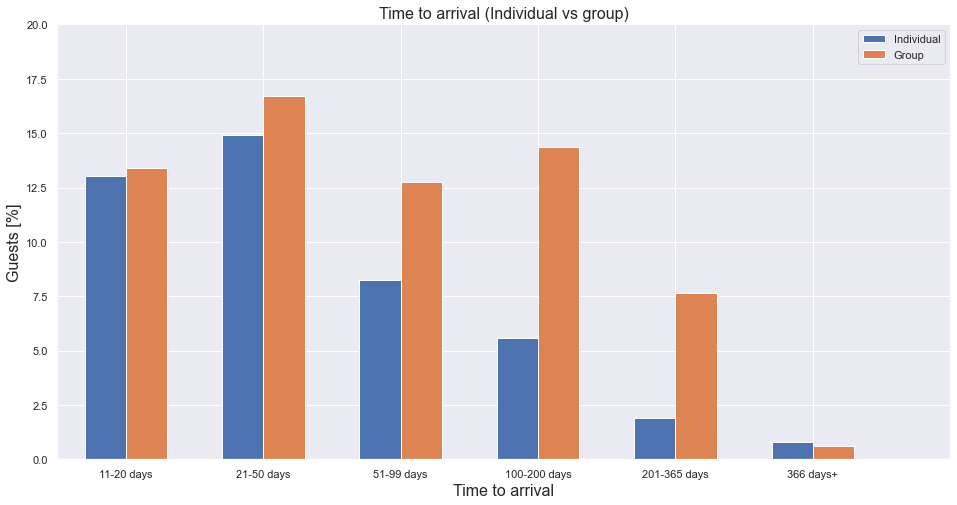

In [ ]:
plt.figure(figsize=(16,8))
x = np.arange(len(tta.tta))
plt.bar(x-0.15, tta.individual_tta_rel, width=0.3, label='Individual')
plt.bar(x+0.15, tta.group_tta_rel, width=0.3, label='Group')
plt.xticks(x, tta.tta)
plt.xlim(0.5,7)
plt.ylim(0,20)
plt.title('Time to arrival (Individual vs group)', fontsize=16)
plt.xlabel('Time to arrival', fontsize=16)
plt.ylabel('Guests [%]', fontsize=16)
plt.legend()
plt.show()

## Hotel occupancy

After focusing on the amount of guests let's look at the number of booked rooms which will be the target variable later when it comes to the forecasting.

In [ ]:
df_rooms = df.groupby(["night__start"])["area"].count().to_frame(name='booked_rooms').reset_index()
max_rooms = df_rooms['booked_rooms'].max()
max_rooms

38

It was confirmed that 38 was in fact the maximum amount of available rooms in the hotel. With this knowledge the occupancy can be calculated.

In [ ]:
df_rooms['occupancy'] = df_rooms['booked_rooms'] / max_rooms * 100
df_rooms['night__start'] = pd.to_datetime(df_rooms['night__start'], format= "%Y-%m-%dT")
df_rooms['month'] = pd.DatetimeIndex(df_rooms['night__start']).month
df_rooms['weekday'] = pd.DatetimeIndex(df_rooms['night__start']).weekday
df_rooms.head(5)

,night__start,booked_rooms,occupancy,month,weekday
0,2015-01-01,15,39.473684,1,3
1,2015-01-02,13,34.210526,1,4
2,2015-01-03,10,26.315789,1,5
3,2015-01-04,6,15.789474,1,6
4,2015-01-05,8,21.052632,1,0


### Monthly occupancy

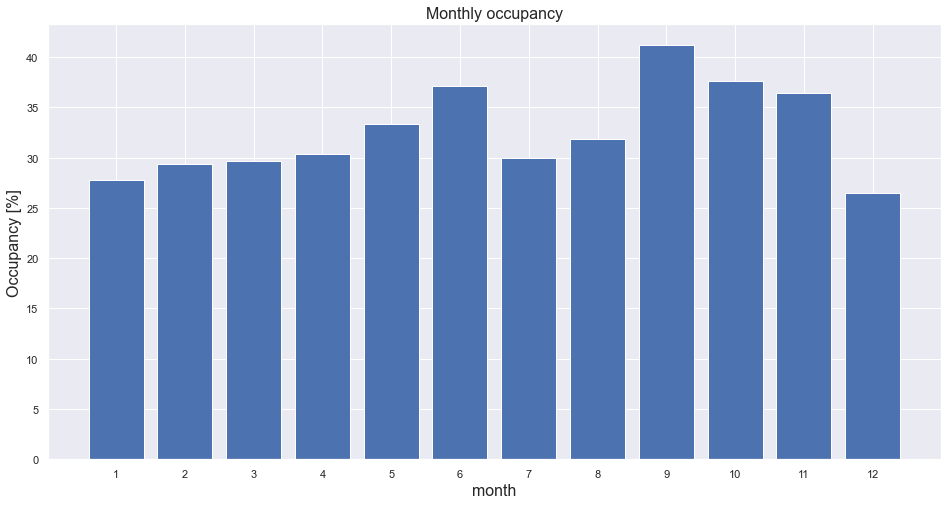

In [ ]:
rooms_monthly = df_rooms.groupby(df_rooms['month'])['occupancy'].mean()

plt.figure(figsize=(16,8))
plt.bar(rooms_monthly.index, rooms_monthly.values)
plt.title('Monthly occupancy', fontsize=16)
plt.xlabel('month', fontsize=16)
plt.ylabel('Occupancy [%]', fontsize=16)
plt.xticks(rooms_monthly.index)
plt.show()

### Occupancy per weekday

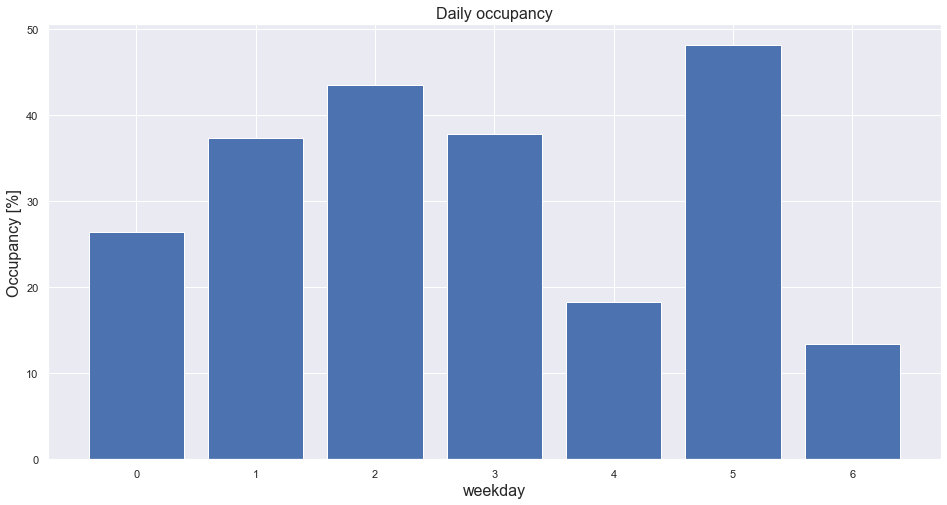

In [ ]:
rooms_monthly = df_rooms.groupby(df_rooms['weekday'])['occupancy'].mean()

plt.figure(figsize=(16,8))
plt.bar(rooms_monthly.index, rooms_monthly.values)
plt.title('Daily occupancy', fontsize=16)
plt.xlabel('weekday', fontsize=16)
plt.ylabel('Occupancy [%]', fontsize=16)
plt.xticks(rooms_monthly.index)
plt.show()

### Occupancy: Individual guests vs groups

In [ ]:
rooms_individual = df[df['bookingGroupId'].isnull()]
rooms_group = df.groupby(["bookingGroupId"]).first()

rooms_individual = rooms_individual.groupby(["night__start"])["area"].count().to_frame(name='booked_rooms').reset_index()
rooms_group = rooms_group.groupby(["night__start"])["area"].count().to_frame(name='booked_rooms').reset_index()

rooms_individual_sum = rooms_individual.sum()
rooms_group_sum = rooms_group.sum()

rooms_individual_perc = rooms_individual_sum / (rooms_individual_sum + rooms_group_sum) * 100
rooms_group_perc = rooms_group_sum / (rooms_individual_sum + rooms_group_sum) * 100

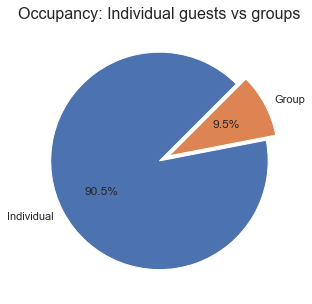

In [ ]:
values = [rooms_individual_perc[0], rooms_group_perc[0]]
labels = ['Individual', 'Group']
explode = (0, 0.1)
plt.figure(figsize=(10,5))
plt.pie(values, labels=labels, explode=explode,autopct='%1.1f%%', startangle=45)
plt.title('Occupancy: Individual guests vs groups', fontsize=16)
plt.show()

## Correlation

For the correlation part a new dataframe will be created that will include the daily number of booked rooms and  guests.

In [ ]:
corr_h1 = df_originial

corr_h1['guests']= corr_h1['adultCount'] + corr_h1['childCount']

corr_h1['night__start'] = pd.to_datetime(corr_h1['night__start'], format= "%Y-%m-%dT%H:%M:%S:%f")
corr_h1['night_date'] = pd.DatetimeIndex(corr_h1['night__start']).date
corr_h1 = corr_h1.set_index(['night_date'])

In [ ]:
#guests per day
numb_guests = corr_h1[corr_h1['status'] != 'CANCELLED']

numb_guests = numb_guests.groupby(['night_date'])['guests'].sum().to_frame(name='guests').reset_index()
numb_guests = numb_guests.set_index(['night_date'])

In [ ]:
#individual guests per day
guests_IG = corr_h1[(corr_h1['bookingGroupId'].isnull()) & (corr_h1['status'] != 'CANCELLED')]
guests_IG = guests_IG.groupby(['night_date'])['guests'].sum().to_frame(name='individual_guests').reset_index()

guests_IG = guests_IG.set_index(['night_date'])

In [ ]:
#group guests per day
guests_GP = corr_h1[(corr_h1['bookingGroupId'].notnull()) & (corr_h1['status'] != 'CANCELLED')]
guests_GP = guests_GP.groupby(['night_date'])['guests'].sum().to_frame(name='group_guests').reset_index()
guests_GP = guests_GP.set_index(['night_date'])

In [ ]:
#number of booked rooms per day 
booked_rooms = corr_h1.groupby(['night_date'])['area'].count().to_frame(name = 'booked_rooms').reset_index()
booked_rooms =booked_rooms.set_index(['night_date'])

In [ ]:
#number of booked rooms that were not cancelled
real_booked_rooms = corr_h1[(corr_h1['status'] != 'CANCELLED')]
real_booked_rooms = real_booked_rooms.groupby(['night_date'])['area'].count().to_frame(name = 'real_booked_rooms').reset_index()
real_booked_rooms = real_booked_rooms.set_index(['night_date'])

In [ ]:
#number of cancelled rooms
cancelled_rooms = corr_h1[(corr_h1['status'] == 'CANCELLED')]
cancelled_rooms = cancelled_rooms.groupby(['night_date'])['area'].count().to_frame(name = 'cancelled_rooms').reset_index()
cancelled_rooms = cancelled_rooms.set_index(['night_date'])

In [ ]:
df_corr = pd.concat([numb_guests, guests_IG, guests_GP, booked_rooms, real_booked_rooms, cancelled_rooms,], axis=1)

In [ ]:
df_corr['day'] = pd.DatetimeIndex(df_corr.index).weekday
df_corr['week'] = pd.DatetimeIndex(df_corr.index).week
df_corr['month'] = pd.DatetimeIndex(df_corr.index).month
df_corr['year'] = pd.DatetimeIndex(df_corr.index).year
df_corr['is_weekend'] = df_corr.day.isin([5,6])*1

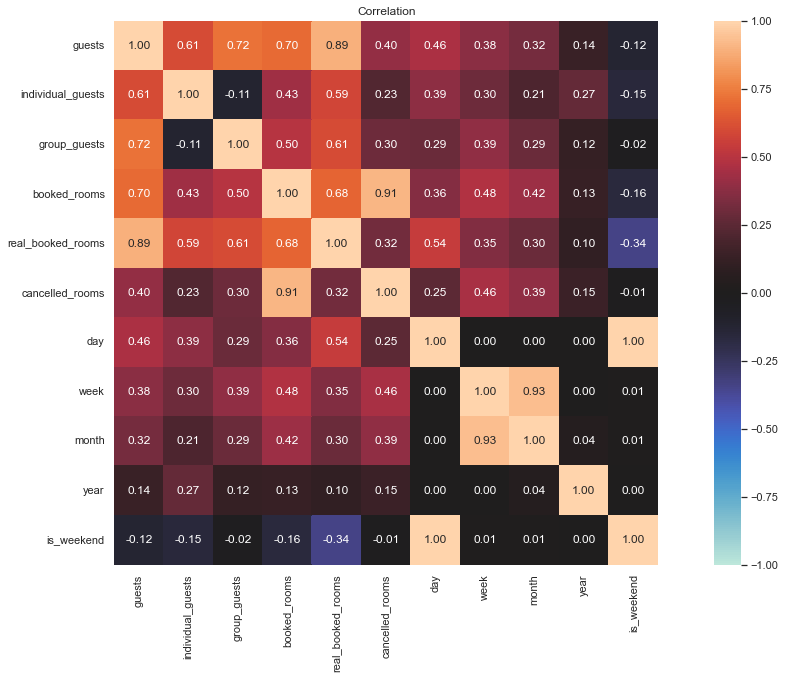

In [ ]:
from dython.nominal import associations

associations(df_corr, figsize=(20,10), title='Correlation', nominal_columns=['day', 'month', 'week', 'year'])
plt.show()

# Creating feature dataframe

The final feature dataframe focuses on the time to arrival for each stay date. To be more precise, the last 365 days are considered for each stay date. Whenever a new booking will be created for a certein date the booked_rooms variable will be increased. Final_booked_rooms is the target variable which will be predicted later. This number describes the final number of rooms that were booked for a certein date.

Let's look at an example: 
01-01-2019 is the stay date which we want to look at. Now lets go 365 days in the past and see if there was a booking created at the 01-01-2018 that had the 01-01-2019 as stay date. Let's say there was someone who booked a room one year in advance and lets increase the number of booked_rooms by 1 (if this booking would be cancelled later, book_rooms will be decreased by 1). Now lets look at the 02-01-2018: Was there a new booking created for the 01-01-2019? No. So the booked_rooms variable stays at 1. This will be done 363 more times until we arrive at the 01-01-2019. Meanwhile the variable final_book_rooms knows how many rooms were booked for the 01-01-2019 and doesn't need to be counted up. So if we look at the 365th dataset for the 01-01-2019 the booked_rooms and final_booked_rooms will show the same number of rooms because the time of arrival equals 0 and we arrived at the final stay date.

Without this approach the algorithm wouldn't know how many rooms were booked already and would always make the assumption that no rooms are booked yet.

The function get_booking_curve_df() will create this feature dataframe and will be used later as a python script.

In [3]:
def get_booking_curve_df(df, start_date :Optional[datetime] = None, end_date: Optional[datetime] = None):
    
    #timezone of the company 
    time_zone = 'Europe/Berlin'
    
    #in this specific case the date are in a unusual string format so we need to transform the str first 
    df['bookingCreatedAt'] = df['bookingCreatedAt'].apply(datetime.strptime, args = ('%Y-%m-%dT%H:%M:%S:%f0',))
    df.loc[~(df['bookingCancelledAt'].isna()), 'bookingCancelledAt'] = df[~(df['bookingCancelledAt'].isna())]['bookingCancelledAt'].apply(datetime.strptime, args = ('%Y-%m-%dT%H:%M:%S:%f0',))
    df['night__start'] = df['night__start'].apply(datetime.strptime, args = ('%Y-%m-%dT%H:%M:%S:%f0',))
    
    df['bookingCreatedAt'] = pd.to_datetime(df['bookingCreatedAt']).dt.tz_localize(pytz.timezone(time_zone))
    df['bookingCancelledAt'] = pd.to_datetime(df['bookingCancelledAt']).dt.tz_localize(pytz.timezone(time_zone))
    df['night__start'] = pd.to_datetime(df['night__start']).dt.tz_localize(pytz.timezone(time_zone))
    
    df_nights = df.copy()
    
    _id = "_id"
    
    if "_id" not in df_nights.columns:
        
        _id = "id"
    
    # create columns whre the start of the stay create and create date is in date is in 
    df_nights['booking_day_start'] = df_nights['bookingCreatedAt'].dt.tz_convert(pytz.timezone(time_zone)).dt.floor('D')
    df_nights['booking_day_start'] = df_nights['booking_day_start'].dt.tz_convert(pytz.UTC)
    df_nights['booking_day_start'] = df_nights['booking_day_start']+ timedelta(days=1)
    #because of the bookkings made erlier then 365 days we ne to make seperate columns 
    #for booked_rooms. 
    df_nights['booking_day_start_'] = df_nights['bookingCreatedAt'].dt.tz_convert(pytz.timezone(time_zone)).dt.floor('D')
    df_nights['booking_day_start_'] = df_nights['booking_day_start'].dt.tz_convert(pytz.UTC)
    df_nights['booking_day_start_'] = df_nights['booking_day_start']+ timedelta(days=1)
    # same for cancellations
    df_nights['cancellation_day_start_'] = df_nights['bookingCancelledAt'].dt.tz_convert(pytz.timezone(time_zone)).dt.floor('D')
    df_nights['cancellation_day_start_'] = df_nights['cancellation_day_start_'].dt.tz_convert(pytz.UTC)
    df_nights['cancellation_day_start_'] = df_nights['cancellation_day_start_'] + timedelta(days=1)
    #for cancellations and stay_date as well
    df_nights['cancellation_day_start'] = df_nights['bookingCancelledAt'].dt.tz_convert(pytz.timezone(time_zone)).dt.floor('D')
    df_nights['cancellation_day_start'] = df_nights['cancellation_day_start'].dt.tz_convert(pytz.UTC)
    df_nights['cancellation_day_start'] = df_nights['cancellation_day_start']+ timedelta(days=1)
    
    df_nights['stay_day_start'] = df_nights['night__start'].dt.tz_convert(pytz.timezone(time_zone)).dt.floor('D')
    df_nights['stay_day_start'] = df_nights['stay_day_start'].dt.tz_convert(pytz.UTC)
    df_nights['stay_day_start'] = df_nights['stay_day_start'] + timedelta(days=1)
    
    # since there are just start date for bookings we need to add the days until the end_date
    if start_date is None:
        start_date = df_nights['stay_day_start'].min()
        
    if end_date is None:
        end_date = df_nights['stay_day_start'].max()
    
    start_date_modified = start_date.astimezone(pytz.timezone(time_zone))
    start_date_modified = pd.to_datetime(start_date_modified.replace(tzinfo=None))
    
    end_date_modified = end_date.astimezone(pytz.timezone(time_zone))
    end_date_modified = pd.to_datetime(end_date_modified.replace(tzinfo=None))
    
    
    diff_to_end_date = (end_date_modified - start_date_modified).days
    
    if diff_to_end_date > 0:
        
        stay_days = (start_date_modified + pd.to_timedelta(np.arange((diff_to_end_date+1)), 'D'))
 
    df_booking_curve = pd.DataFrame({'start_date': stay_days})
    
    df_copy = df_booking_curve.copy()
    
    #we need to transform the date into company timezone so we can add days and all create dates are in the same timezone
    
    df_booking_curve['create_date'] = df_booking_curve['start_date']
    
    
    
    for i in range(1,366):
        df_copy['create_date'] = df_copy['start_date'] + pd.Timedelta(f"{-i} days")
    
        df_booking_curve = df_booking_curve.append(df_copy, ignore_index = True)

    #need to flor again because in summertime time.delta adds an hour, tranform back to utc and sort it
    df_booking_curve['create_date'] = df_booking_curve['create_date'].dt.tz_localize(pytz.timezone(time_zone))
    df_booking_curve['start_date'] = df_booking_curve['start_date'].dt.tz_localize(pytz.timezone(time_zone))
    
    df_booking_curve['create_date'] = df_booking_curve['create_date'].dt.tz_convert(pytz.UTC)
    df_booking_curve['start_date'] = df_booking_curve['start_date'].dt.tz_convert(pytz.UTC)
    
    df_booking_curve = df_booking_curve.sort_values(['start_date', 'create_date'])
    
    
    #### put it here because we need the stay_day_start_column to have UTC time-info
    # for all bookings and cancellations made befor 365 days we set the create date of column used for booked_rooms
    # to 365 days before stay_date. if the viewed time period will get increased this needs to be adjusted
    df_nights['min_dates'] = df_nights['stay_day_start'] - pd.Timedelta(f"{365} days")
    
    df_nights.loc[df_nights['booking_day_start_'] < df_nights['min_dates'], 'booking_day_start_'] = df_nights[df_nights['booking_day_start_'] < df_nights['min_dates']]['min_dates']    
    df_nights.loc[df_nights['cancellation_day_start_'] < df_nights['min_dates'], 'cancellation_day_start_'] = df_nights[df_nights['cancellation_day_start_'] < df_nights['min_dates']]['min_dates']
    
    
    # create dictionary for the bookings to map it later
    dict_bookings = df_nights.groupby(['stay_day_start','booking_day_start'])[_id].count().to_dict()
    dict_bookings_ = df_nights.groupby(['stay_day_start','booking_day_start_'])[_id].count().to_dict()
    
    #dictionary for cancellations
    dict_cancellations = df_nights.groupby(['stay_day_start','cancellation_day_start'])[_id].count().to_dict()
    dict_cancellations_ = df_nights.groupby(['stay_day_start','cancellation_day_start_'])[_id].count().to_dict()
    
    df_booking_curve['new_booked_rooms'] = df_booking_curve.set_index(['start_date', 'create_date']).index.map(dict_bookings.get)
    df_booking_curve.loc[df_booking_curve['new_booked_rooms'].isna(), 'new_booked_rooms'] = 0
    df_booking_curve['new_booked_rooms'] = pd.to_numeric(df_booking_curve['new_booked_rooms'])

    df_booking_curve['cancellations'] = df_booking_curve.set_index(['start_date', 'create_date']).index.map(dict_cancellations.get)
    df_booking_curve.loc[df_booking_curve['cancellations'].isna(), 'cancellations'] = 0
    df_booking_curve['cancellations'] = pd.to_numeric(df_booking_curve['cancellations'])
    
    #need to take different columns for bookings because of the activities earlier than 365
    df_booking_curve['cancellations_'] = df_booking_curve.set_index(['start_date', 'create_date']).index.map(dict_cancellations_.get)
    df_booking_curve.loc[df_booking_curve['cancellations_'].isna(), 'cancellations_'] = 0
    df_booking_curve['cancellations_'] = pd.to_numeric(df_booking_curve['cancellations_'])
    
    df_booking_curve['booked_rooms'] = df_booking_curve.set_index(['start_date', 'create_date']).index.map(dict_bookings_.get)
    df_booking_curve.loc[df_booking_curve['booked_rooms'].isna(), 'booked_rooms'] = 0
    df_booking_curve['booked_rooms'] = pd.to_numeric(df_booking_curve['booked_rooms'])
    
    df_booking_curve['booked_rooms'] = df_booking_curve['booked_rooms'] - df_booking_curve['cancellations_']
    df_booking_curve['booked_rooms'] = df_booking_curve.groupby('start_date')['booked_rooms'].cumsum()
    
    df_booking_curve['create_date'] = pd.to_datetime(df_booking_curve['create_date'], format= "%Y-%m-%dT%H:%M:%S:%f").dt.date
    df_booking_curve['start_date'] = pd.to_datetime(df_booking_curve['start_date'], format= "%Y-%m-%dT%H:%M:%S:%f").dt.date

    df_booking_curve['day'] = pd.DatetimeIndex(df_booking_curve['start_date']).weekday
    df_booking_curve['month'] = pd.DatetimeIndex(df_booking_curve['start_date']).month
    df_booking_curve['week'] = pd.DatetimeIndex(df_booking_curve['start_date']).week
    
    df_booking_curve[['start_date','create_date']] = df_booking_curve[['start_date','create_date']].apply(pd.to_datetime) #if conversion required
    df_booking_curve['time_to_arrival'] = (df_booking_curve['start_date'] - df_booking_curve['create_date']).dt.days
    
    #final_booked_rooms = booked Rooms with Time to arrival == 0
    dummyBookedRooms = df_booking_curve[(df_booking_curve['time_to_arrival'] == 0)]
    dummyBookedRooms.rename(columns={'booked_rooms': 'final_booked_rooms'}, inplace=True)
    dummyBookedRooms = dummyBookedRooms[['start_date', 'final_booked_rooms']]
    df_booking_curve = pd.merge(left=df_booking_curve, right=dummyBookedRooms, how='left', left_on='start_date', right_on='start_date')
        
    #dummies for weekday
    df_booking_curve['monday'] = np.where(df_booking_curve['day'].isin([0]), 1, 0)
    df_booking_curve['tuesday'] = np.where(df_booking_curve['day'].isin([1]), 1, 0)
    df_booking_curve['wednesday'] = np.where(df_booking_curve['day'].isin([2]), 1, 0)
    df_booking_curve['thursday'] = np.where(df_booking_curve['day'].isin([3]), 1, 0)
    df_booking_curve['friday'] = np.where(df_booking_curve['day'].isin([4]), 1, 0)
    df_booking_curve['saturday'] = np.where(df_booking_curve['day'].isin([5]), 1, 0)
    df_booking_curve['sunday'] = np.where(df_booking_curve['day'].isin([6]), 1, 0)
    
    
    return (df_booking_curve[[
            'booked_rooms',
            'time_to_arrival',
            'final_booked_rooms',
            'week',
            'monday',
            'tuesday',
            'wednesday',
            'thursday',
            'friday',
            'saturday',
            'sunday'
    ]])

In [24]:
df_feat = pd.read_excel('hotel_data.xlsx')

#Because group bookings make only a small percentage of the total occupancy and also appear very random throughout the year, 
# the algorithm should focus on the forecast of booked rooms by individual guests.
df_feat = df_feat[df_feat['bookingGroupId'].isnull()]

df_feat = get_booking_curve_df(df_feat)

In [25]:
df_feat.tail(5)

,booked_rooms,time_to_arrival,final_booked_rooms,week,monday,tuesday,wednesday,thursday,friday,saturday,sunday
670873,24.0,4,25.0,1,0,1,0,0,0,0,0
670874,24.0,3,25.0,1,0,1,0,0,0,0,0
670875,25.0,2,25.0,1,0,1,0,0,0,0,0
670876,26.0,1,25.0,1,0,1,0,0,0,0,0
670877,25.0,0,25.0,1,0,1,0,0,0,0,0


## Replace the week variable with a seasonality value

Working with the week as a feature would lead to data leaking. Thats why the week will be replaced by a seasonality value which will be calculated with the help of a sine curve in the following part.

In [26]:
df_curve = df_feat
df_curve = df_curve[df_curve['time_to_arrival'] == 0]
df_curve = df_curve[['final_booked_rooms', 'week']]
df_curve = df_curve.groupby(['week'])['final_booked_rooms'].mean()

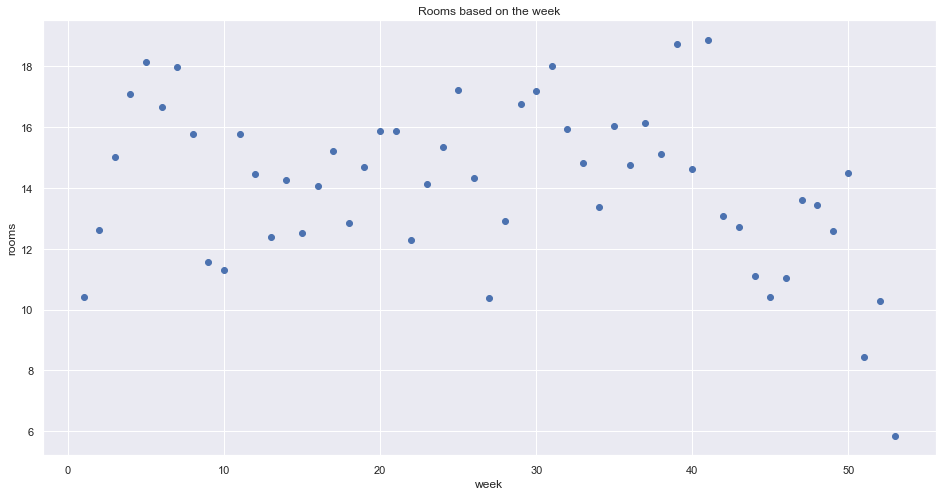

In [27]:
plt.figure(figsize=(16, 8))
plt.scatter(df_curve.index,df_curve)
plt.title('Rooms based on the week')
plt.xlabel('week')
plt.ylabel('rooms')
plt.show()

In [28]:
from scipy.optimize import curve_fit
def mysine( X, A, c, d,E,f, g):
    return A*np.sin(2*np.pi/53*(X - c)) + d + E*np.sin(2*np.pi/f*(X - g))

popt, pcov = curve_fit(mysine, df_curve.index, df_curve, maxfev = 10000)

In [29]:
df_feat['seasonality'] = mysine(df_feat['week'], *popt)

In [30]:
df_seasonality = df_feat.groupby('week').mean()

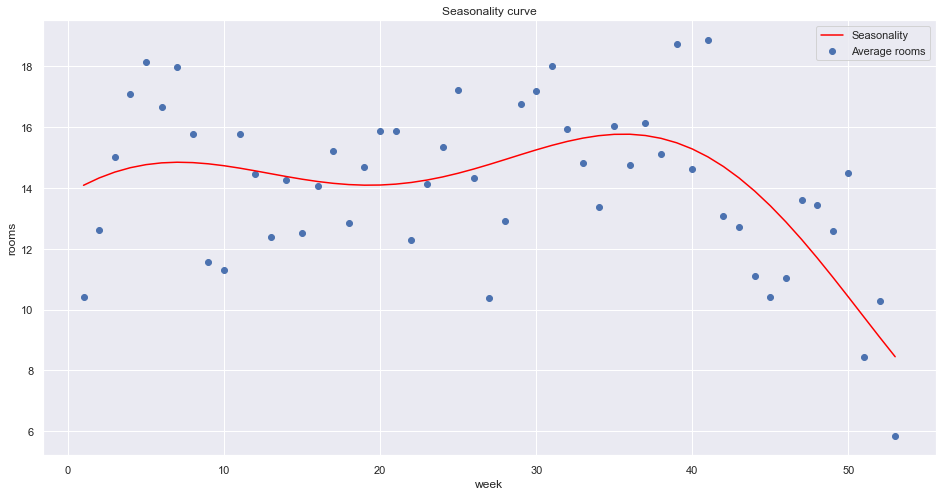

In [31]:
plt.figure(figsize=(16, 8))
plt.scatter(df_seasonality.index, df_seasonality.final_booked_rooms, label='Average rooms')
plt.plot(df_seasonality.index, df_seasonality.seasonality, color='red', label='Seasonality')
plt.title('Seasonality curve')
plt.xlabel('week')
plt.ylabel('rooms')
plt.legend()
plt.show()

# Finding the right model

In [32]:
df_feat = df_feat.drop('week', axis=1)

X = df_feat.drop(['final_booked_rooms'], axis=1)
y = df_feat['final_booked_rooms']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [ ]:
models = [['LinearRegression : ', LinearRegression()],
          ['ElasticNet :', ElasticNet()],
          ['Lasso : ', Lasso()],
          ['Ridge : ', Ridge()],
          ['DecisionTreeRegressor : ', DecisionTreeRegressor()],
          ['RandomForestRegressor : ', RandomForestRegressor()],
          ['AdaBoostRegressor : ', AdaBoostRegressor()],
          ['GradientBoostingRegressor : ', GradientBoostingRegressor()],
          ['ExtraTreeRegressor : ', ExtraTreeRegressor()],
          ['XGBRegressor : ', XGBRegressor()],
          ['BayesianRidge : ', BayesianRidge()]]

In [ ]:
for name, model in models:
    model=model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name, (mean_absolute_error(y_test, predictions)))

LinearRegression :  4.919072496018204
ElasticNet : 6.049824755640079
Lasso :  6.200147440738259
Ridge :  4.919185334374612
DecisionTreeRegressor :  4.185612056801018
RandomForestRegressor :  4.002238862939612
AdaBoostRegressor :  5.497168571684842
GradientBoostingRegressor :  4.474436598719706
ExtraTreeRegressor :  4.181142678273313
XGBRegressor :  3.7486620102271417
BayesianRidge :  4.919189997187664


XGBRegressor showed the best score without any hyperparameter optimization. That's why it will be used for this regression problem.

In [ ]:
algorithms = {
    'XGBRegressor' : {
        'model' : XGBRegressor(),
        'param' : {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3,6,10],
            'n_estimators': [100, 500, 1000],
            'colsample_bytree': [0.3, 0.7]
        }
    }
}

In [ ]:
score = []

for name, mp in algorithms.items() :
    rs = GridSearchCV(estimator = mp['model'], param_grid= mp['param'], n_jobs=-1)
    rs.fit(X_train, y_train)
    score.append({
        'model': name,
        'score' : rs.best_score_,
        'params' : rs.best_params_
    })
final = pd.DataFrame(score, columns=['model', 'score', 'params'])
score[0]

{'model': 'XGBRegressor',
 'score': 0.6501532737872712,
 'params': {'colsample_bytree': 0.7,
  'learning_rate': 0.05,
  'max_depth': 10,
  'n_estimators': 500}}

In [34]:
XGB = XGBRegressor(max_depth = 10, n_estimators = 500, learning_rate=0.05, colsample_bytree = 0.7, n_jobs = 6)
XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [35]:
pred = XGB.predict(X_test)
mean_absolute_error(y_test, pred)

3.4991159692963554

In [ ]:
cv_scores = cross_val_score(XGB, X_train, y_train, cv = 8)
print('Mean Score of CV: ', cv_scores.mean())

Mean Score of CV:  0.6513736709588398


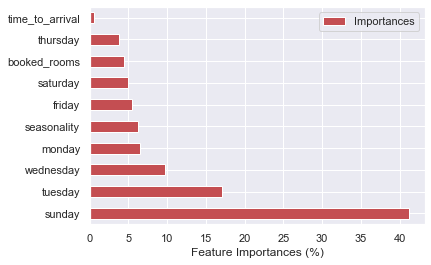

In [36]:
pd.DataFrame(data = XGB.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")
plt.show()